In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [5]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

In [6]:
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X_poly, y)

In [7]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_selected, y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
logreg = LogisticRegression(max_iter=1000)
param_dist_logreg = {'C': uniform(0.01, 10)}
rand_logreg = RandomizedSearchCV(logreg, param_distributions=param_dist_logreg, n_iter=100, cv=5, random_state=42)
rand_logreg.fit(X_train_scaled, y_train)
best_logreg = rand_logreg.best_estimator_

In [11]:
knn = KNeighborsClassifier()
param_dist_knn = {'n_neighbors': randint(1, 50), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}
rand_knn = RandomizedSearchCV(knn, param_distributions=param_dist_knn, n_iter=100, cv=5, random_state=42)
rand_knn.fit(X_train_scaled, y_train)
best_knn = rand_knn.best_estimator_

In [12]:
svm = SVC(probability=True)
param_dist_svm = {'C': uniform(0.1, 10), 'kernel': ['linear', 'rbf']}
rand_svm = RandomizedSearchCV(svm, param_distributions=param_dist_svm, n_iter=100, cv=5, random_state=42)
rand_svm.fit(X_train_scaled, y_train)
best_svm = rand_svm.best_estimator_

In [13]:
dt = DecisionTreeClassifier()
param_dist_dt = {'max_depth': randint(1, 20), 'min_samples_split': randint(2, 20)}
rand_dt = RandomizedSearchCV(dt, param_distributions=param_dist_dt, n_iter=100, cv=5, random_state=42)
rand_dt.fit(X_train_scaled, y_train)
best_dt = rand_dt.best_estimator_

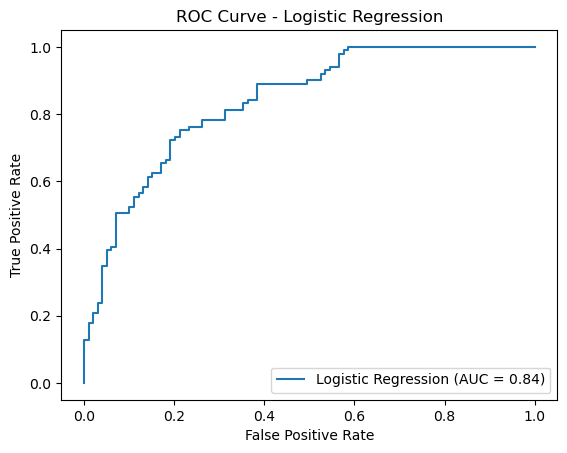

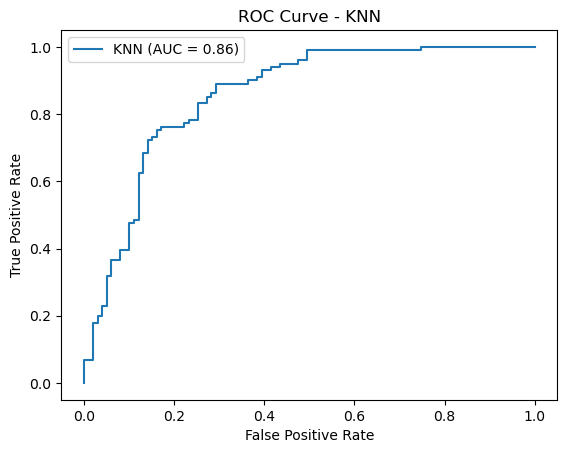

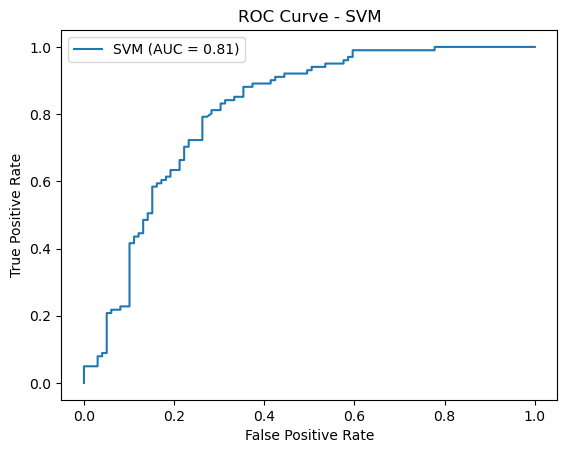

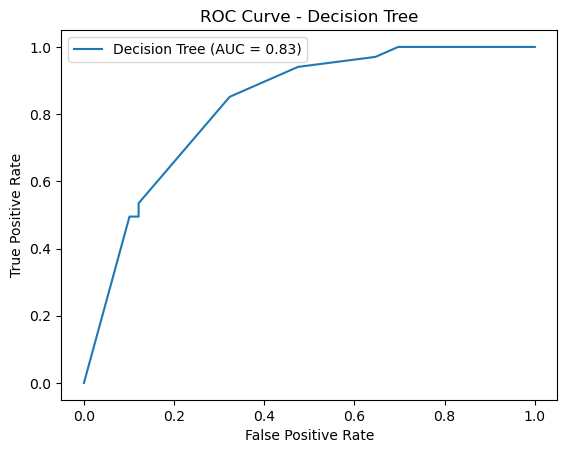

In [14]:
models = {
    'Logistic Regression': best_logreg,
    'KNN': best_knn,
    'SVM': best_svm,
    'Decision Tree': best_dt
}

accuracies = []
auc_scores = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    accuracies.append(accuracy)
    auc_scores.append(auc)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.show()

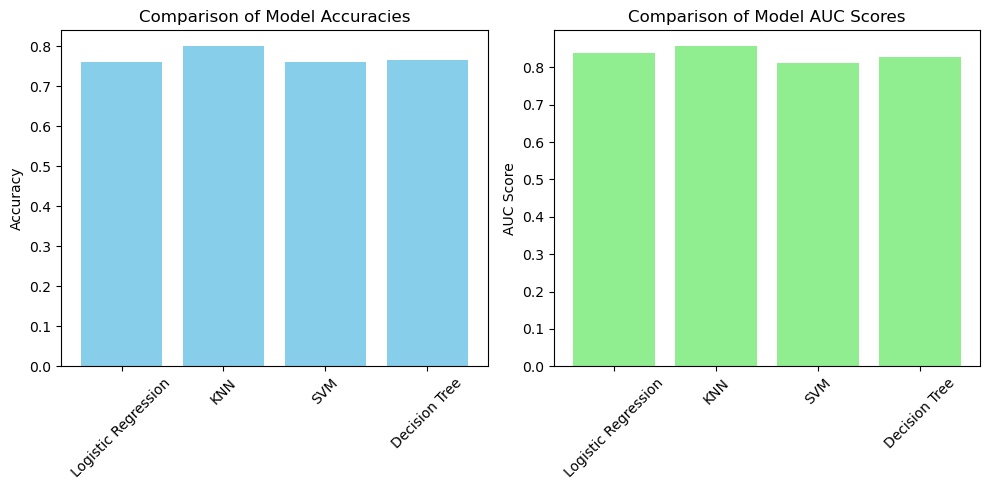

In [15]:
model_names = list(models.keys())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, accuracies, color='skyblue')
plt.title('Comparison of Model Accuracies')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(model_names, auc_scores, color='lightgreen')
plt.title('Comparison of Model AUC Scores')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()